f=1, g=0. Domain: square [-1,1]^2 with moving crack from (0,0) to (1,alpha(t))

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FFMpegWriter

# Settings
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

X_MIN, X_MAX = -1.0, 1.0
Y_MIN, Y_MAX = -1.0, 1.0
T_MIN, T_MAX = 0.0, 0.25  

N_f = 1000      
N_b_outer = 1000 
N_b_crack = 1000 
N_ic = 1000 # initial condition points on domain at t=0
N_ic_out = 1000  # initial condition points on domain at t=0
N_ic_crack = 1000   # initial condition points on domain at t=0
epochs = 4000
lambda_bc = 1.0
lambda_ic = 1.0
lambda_zz = 1.0
lambda_zz3 = 1.0 
lambda_zz2 = 0.0 # 暫時沒用到





Device: cpu


In [24]:
# MLP 
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.ModuleList()
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = torch.tanh
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) #????
                nn.init.zeros_(m.bias)

    def forward(self, inp):
        z = inp
        for layer in self.net[:-1]:
            z = self.activation(layer(z))
        z = self.net[-1](z)
        return z

layers = [4, 64, 64, 1]
model = MLP(layers).to(device)     

In [25]:
def alpha(t):
    return (np.pi / 4.0) * torch.sin(2.0 * np.pi * t)

def compute_phi_and_derivs(x, y, t):
    eps = 1e-12
    x = x.view(-1, 1).to(device)
    y = y.view(-1, 1).to(device)
    t = t.view(-1, 1).to(device)
    a = alpha(t)  # α(t)
    r = torch.sqrt(torch.clamp(x**2 + y**2, min=eps))
    inside = torch.clamp(r - (x * torch.cos(a) + y * torch.sin(a)), min=eps)
    phi = torch.sqrt(0.5 * inside)
    sqrt_term = torch.sqrt(inside)
    phi_x = (torch.sqrt(torch.tensor(2.0, dtype=torch.float64)) *
             (x / r - torch.cos(a))) / (4.0 * sqrt_term)
    phi_y = (torch.sqrt(torch.tensor(2.0, dtype=torch.float64)) *
             (y / r - torch.sin(a))) / (4.0 * sqrt_term)
    phi_t = (torch.sqrt(torch.tensor(2.0, dtype=torch.float64)) / 4.0 *
             (x * torch.sin(a) - y * torch.cos(a)) / sqrt_term *
             (np.pi**2 / 2.0) * torch.cos(2 * np.pi * t))

    return phi, phi_x, phi_y, phi_t

def partials_U_wrt_inputs(model, x, y, phi, t):
    # ensure column shapes
    x = x.view(-1,1)
    y = y.view(-1,1)
    phi = phi.view(-1,1)
    t = t.view(-1,1)

    inp = torch.cat([x, y, phi, t], dim=1).to(device)
    inp.requires_grad_(True)
    U = model(inp)  # (N,1)

    grads = torch.autograd.grad(U, inp, grad_outputs=torch.ones_like(U),
                                create_graph=True, retain_graph=True)[0]  # (N,4)
    U_x = grads[:,0:1]
    U_y = grads[:,1:2]
    U_z = grads[:,2:3]   
    U_t = grads[:,3:4]   
    return U, inp, U_x, U_y, U_z, U_t

def second_partials_U(model, inp, U_x, U_y, U_z):
    # inp shape (N,4)
    grad_Ux = torch.autograd.grad(U_x, inp, grad_outputs=torch.ones_like(U_x),
                                  create_graph=True, retain_graph=True)[0]
    grad_Uy = torch.autograd.grad(U_y, inp, grad_outputs=torch.ones_like(U_y),
                                  create_graph=True, retain_graph=True)[0]
    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z),
                                  create_graph=True, retain_graph=True)[0]

    U_xx = grad_Ux[:,0:1]
    U_xz = grad_Ux[:,2:3]
    U_yy = grad_Uy[:,1:2]
    U_yz = grad_Uy[:,2:3]
    U_zz = grad_Uz[:,2:3]

    return U_xx, U_yy, U_xz, U_yz, U_zz

# compute residual (u_t - Laplace u - f)
def compute_residual_time(model, x, y, t):
    # take phi and its derivs (using autograd internally)
    x_in = x.clone().detach().requires_grad_(True).to(device)
    y_in = y.clone().detach().requires_grad_(True).to(device)
    t_in = t.clone().detach().requires_grad_(True).to(device)

    phi, phi_x, phi_y, phi_t = compute_phi_and_derivs(x_in, y_in, t_in)

    U, inp, U_x, U_y, U_z, U_t = partials_U_wrt_inputs(model, x_in, y_in, phi, t_in)
    U_xx, U_yy, U_xz, U_yz, U_zz = second_partials_U(model, inp, U_x, U_y, U_z)

    r = torch.sqrt(torch.clamp(x**2 + y**2, min=1e-12))
    laplace_U = U_xx + U_yy
    lap = laplace_U + 2.0 * (U_xz * phi_x + U_yz * phi_y) + (1/(4*r)) * U_zz

    # ut = U_z * phi_t + U_t
    ut = U_z * phi_t + U_t
    residual = ut - lap - 1.0
    return residual, U, U_zz, U_xz, U_yz

# compute tip constraint 
def compute_zz_uN(model, t):
    if not torch.is_tensor(t):
        t = torch.tensor([[t]], dtype=torch.float64, device=device)
    else:
        t = t.view(-1,1).to(dtype=torch.float64, device=device)

    x = torch.zeros_like(t)
    y = torch.zeros_like(t)

    phi, phi_x, phi_y, phi_t = compute_phi_and_derivs(x, y, t)
    U, inp, U_x, U_y, U_z, U_t = partials_U_wrt_inputs(model, x, y, phi, t)

    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z),
                                  create_graph=True, retain_graph=True)[0]
    U_zz = grad_Uz[:,2:3]
    U_xz = grad_Uz[:,0:1]
    U_yz = grad_Uz[:,1:2]
    return torch.mean(U_zz**2 + U_xz**2 + U_yz**2) 

def compute_xyz_uN(model, x, y, t):
    phi, phi_x, phi_y, phi_t  = compute_phi_and_derivs(x, y, t)
    U, inp, U_x, U_y, U_z, U_t = partials_U_wrt_inputs(model, x, y, phi, t)
    grad_Uz = torch.autograd.grad(U_z, inp, grad_outputs=torch.ones_like(U_z),
                                  create_graph=True, retain_graph=True)[0]
    U_xz = grad_Uz[:,0:1]
    U_yz = grad_Uz[:,1:2]

    return torch.mean(U_xz**2+U_yz**2)  # shape (N,1)


def compute_crack_Uz_zero(model, x, y, t): #暫時沒用到
    phi, phi_x, phi_y, phi_t = compute_phi_and_derivs(x, y, t)
    U, inp, U_x, U_y, U_z, U_t = partials_U_wrt_inputs(model, x, y, phi, t)
    return torch.mean(U_z**2)

# sampling
def sample_collocation(N): 
    x = torch.rand(N*2,1) * (X_MAX - X_MIN) + X_MIN 
    y = torch.rand(N*2,1) * (Y_MAX - Y_MIN) + Y_MIN 
    t = torch.rand(N*2,1) * (T_MAX - T_MIN) + T_MIN 
    a = alpha(t) # shape (N*2,1) 
    # 裂縫 y = α(t)*x  點到直線距離 
    dist_to_crack = torch.abs(y - a * x) / torch.sqrt(1 + a**2) 
    # mask 
    mask_crack = (dist_to_crack < 1e-8) 
    x, y, t = x[~mask_crack][:N], y[~mask_crack][:N], t[~mask_crack][:N] 
    return x.to(device), y.to(device), t.to(device)

def sample_outer_boundary(N):
    per_side = max(4, N // 4)
    xs, ys = [], []

    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1)); xs.append(torch.ones_like(ys[-1]) * X_MIN)
    ys.append(torch.linspace(Y_MIN, Y_MAX, per_side).unsqueeze(1)); xs.append(torch.ones_like(ys[-1]) * X_MAX)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1)); ys.append(torch.ones_like(xs[-1]) * Y_MIN)
    xs.append(torch.linspace(X_MIN, X_MAX, per_side).unsqueeze(1)); ys.append(torch.ones_like(xs[-1]) * Y_MAX)

    x = torch.cat(xs, dim=0)[:N]
    y = torch.cat(ys, dim=0)[:N]
    t = torch.rand(N, 1, device=device, dtype=torch.float64) * (T_MAX - T_MIN) + T_MIN

    return x.to(device), y.to(device), t


def sample_crack_boundary(N):
    t = torch.rand(N, 1, device=device, dtype=torch.float64) * (T_MAX - T_MIN) + T_MIN
    x_vals = torch.linspace(0, 1, N, device=device, dtype=torch.float64).unsqueeze(1)
    y_vals = x_vals * alpha(t)
    return x_vals, y_vals, t

def sampling_points(N_f, N_b_crack, N_b_outer):
    x_f, y_f, t_f = sample_collocation(N_f)
    x_b_out, y_b_out, t_b_out = sample_outer_boundary(N_b_outer)
    x_b_crack, y_b_crack, t_b_crack = sample_crack_boundary(N_b_crack)

    x_f = x_f.view(-1,1); y_f = y_f.view(-1,1); t_f = t_f.view(-1,1)
    x_b_out = x_b_out.view(-1,1); y_b_out = y_b_out.view(-1,1); t_b_out = t_b_out.view(-1,1)
    x_b_crack = x_b_crack.view(-1,1); y_b_crack = y_b_crack.view(-1,1); t_b_crack = t_b_crack.view(-1,1)
    
    x_b = torch.cat([x_b_out, x_b_crack])
    y_b = torch.cat([y_b_out, y_b_crack])
    t_b = torch.cat([t_b_out, t_b_crack])

    phi_b, _, _, _ = compute_phi_and_derivs(x_b, y_b, t_b)
    inp_bc = torch.cat([x_b, y_b, phi_b, t_b.detach()], dim=1)

    return x_f, y_f, t_f, x_b_out, y_b_out, t_b_out, x_b_crack, y_b_crack, t_b_crack, inp_bc, x_b    

In [26]:
# training points 
x_f, y_f, t_f, x_b_out, y_b_out, t_b_out, x_b_crack, y_b_crack, t_b_crack, inp_bc, x_b = sampling_points(N_f, N_b_crack, N_b_outer)
x_ic_f, y_ic_f, _, x_ic_out, y_ic_out, _, _, _, _, _, _ = sampling_points(N_ic, N_ic_out, N_ic_crack)
x_ic = torch.cat([x_ic_f, x_ic_out]); y_ic = torch.cat([y_ic_f, y_ic_out]); t_ic = torch.zeros_like(x_ic)
phi_ic, _, _, _= compute_phi_and_derivs(x_ic, y_ic, t_ic)
inp_ic = torch.cat([x_ic, y_ic, phi_ic, t_ic], dim=1)
# validation points
(
    x_f_val, y_f_val, t_f_val,
    x_b_out_val, y_b_out_val, t_b_out_val,
    x_b_crack_val, y_b_crack_val, t_b_crack_val,
    inp_bc_val, x_b_val
) = sampling_points(N_f, N_b_crack, N_b_outer)
x_ic_f_val, y_ic_f_val, _, x_ic_out_val, y_ic_out_val, _, _, _, _, _, _ = sampling_points(N_ic, N_ic_out, N_ic_crack)
x_ic_val = torch.cat([x_ic_f_val, x_ic_out_val]); y_ic_val = torch.cat([y_ic_f_val, y_ic_out_val]); t_ic_val = torch.zeros_like(x_ic_val)
phi_ic_val, _, _, _ = compute_phi_and_derivs(x_ic_val, y_ic_val, t_ic_val)
inp_ic_val = torch.cat([x_ic_val, y_ic_val, phi_ic_val, t_ic_val], dim=1)

# g=0 on boundary
g_b = torch.zeros_like(x_b, device=device)

# initial condition t=0: u(x,y,0)=0
u0 = torch.zeros_like(x_ic).to(device)
u0_val = torch.zeros_like(x_ic_val).to(device)
##
g_b_val = torch.zeros_like(x_b_val, device=device)

###
# optimizer
optimizer = optim.LBFGS(model.parameters(), lr=1.0, max_iter=20, history_size=50, line_search_fn="strong_wolfe")

print("Start training (time-dependent PINN)")

loss_history = []
val_history = []

for ep in range(epochs):
    def closure():
        optimizer.zero_grad()
        residual_f, _, Uzz_f, Uxz_f, Uyz_f = compute_residual_time(model, x_f, y_f, t_f)
        loss_pde = torch.mean(residual_f**2)
        u_bc = model(inp_bc)
        loss_bc = torch.mean((u_bc - g_b)**2)
        u_ic_pred = model(inp_ic)
        loss_ic = torch.mean((u_ic_pred - u0)**2)
        loss_zz = compute_zz_uN(model, t_b_crack)
        loss_yxz = compute_xyz_uN(model, x_b_crack, y_b_crack, t_b_crack)
        loss_Uz_crack = compute_crack_Uz_zero(model, x_b_crack, y_b_crack, t_b_crack)
        loss = (loss_pde
        + lambda_bc * loss_bc
        + lambda_ic * loss_ic
        + lambda_zz * loss_zz
        + lambda_zz3 * loss_yxz
        + lambda_zz2 * loss_Uz_crack)
        loss.backward()
        return loss

    loss = optimizer.step(closure)
    loss_history.append(loss.item())
        # resampling 
    if ep % 50 == 0 and ep > 0:
        print(f"\n[Resample] epoch {ep}: regenerating PDE/BC/IC points...\n")

        x_f, y_f, t_f, x_b_out, y_b_out, t_b_out, x_b_crack, y_b_crack, t_b_crack, inp_bc, x_b = sampling_points(N_f, N_b_crack, N_b_outer)
        x_ic_f, y_ic_f, _, x_ic_out, y_ic_out, _, _, _, _, _, _ = sampling_points(N_ic, N_ic_out, N_ic_crack)
        x_ic = torch.cat([x_ic_f, x_ic_out], dim=0); y_ic = torch.cat([y_ic_f, y_ic_out], dim=0); t_ic = torch.zeros_like(x_ic)
        phi_ic, _, _, _ = compute_phi_and_derivs(x_ic, y_ic, t_ic)
        inp_ic = torch.cat([x_ic, y_ic, phi_ic, t_ic], dim=1)    

    if ep % 10 == 0 or ep == epochs-1:
        # validation 
            res_val, _, Uzz_val, Uxz_val, Uyz_val = compute_residual_time(model, x_f_val, y_f_val, t_f_val)
            loss_pde_val = torch.mean(res_val**2)
            u_bc_val = model(inp_bc_val)
            loss_bc_val = torch.mean((u_bc_val - g_b_val)**2)
            u_ic_pred_val = model(inp_ic_val)
            loss_ic_val = torch.mean((u_ic_pred_val - u0_val)**2)
            loss_zz_val = compute_zz_uN(model, t_b_crack_val)
            loss_yxz_val = compute_xyz_uN(model, x_b_crack_val, y_b_crack_val, t_b_crack_val)
            loss_Uz_crack_val = compute_crack_Uz_zero(model, x_b_crack_val, y_b_crack_val, t_b_crack_val)
            loss_val = (
                loss_pde_val
                + lambda_bc * loss_bc_val
                + lambda_ic * loss_ic_val
                + lambda_zz * loss_zz_val
                + lambda_zz3 * loss_yxz_val
                + lambda_zz2 * loss_Uz_crack_val)
            val_history.append(loss_val.item())
            # training loss 細項, print 用
            res_f, _, _, _, _ = compute_residual_time(model, x_f, y_f, t_f)
            loss_pde = torch.mean(res_f**2)
            loss_bc = torch.mean((model(inp_bc) - g_b)**2)
            loss_ic = torch.mean((model(inp_ic) - u0)**2)
            loss_zz = compute_zz_uN(model, t_b_crack)
            loss_yxz = compute_xyz_uN(model, x_b_crack, y_b_crack, t_b_crack)
            loss_Uz_crack = compute_crack_Uz_zero(model, x_b_crack, y_b_crack, t_b_crack)

            print(
            f"Epoch {ep:4d} | "
            f"TrainLoss={loss.item():.3e} "
            f"(pde={loss_pde:.2e}, bc={loss_bc:.2e}, ic={loss_ic:.2e}, "
            f"zz={loss_zz:.2e}, yxz={loss_yxz:.2e} | "
            f"ValLoss={loss_val.item():.3e} "
            f"(pde={loss_pde_val:.2e}, bc={loss_bc_val:.2e}, ic={loss_ic_val:.2e}, "
            f"zz={loss_zz_val:.2e}, yxz={loss_yxz_val:.2e})")            

print("Training finished.")


Start training (time-dependent PINN)
Epoch    0 | TrainLoss=2.062e+00 (pde=8.91e-04, bc=7.28e-03, ic=3.05e-03, zz=5.39e-05, yxz=3.35e-04 | ValLoss=1.142e-02 (pde=8.63e-04, bc=7.18e-03, ic=2.99e-03, zz=5.26e-05, yxz=3.34e-04)
Epoch   10 | TrainLoss=6.222e-03 (pde=1.24e-03, bc=3.19e-03, ic=1.19e-03, zz=3.53e-05, yxz=9.23e-05 | ValLoss=5.968e-03 (pde=1.53e-03, bc=3.16e-03, ic=1.15e-03, zz=3.45e-05, yxz=9.31e-05)
Epoch   20 | TrainLoss=3.633e-03 (pde=7.04e-04, bc=2.12e-03, ic=5.87e-04, zz=1.37e-05, yxz=5.57e-05 | ValLoss=3.762e-03 (pde=1.00e-03, bc=2.11e-03, ic=5.79e-04, zz=1.33e-05, yxz=5.46e-05)
Epoch   30 | TrainLoss=2.921e-03 (pde=6.50e-04, bc=1.77e-03, ic=3.72e-04, zz=2.44e-05, yxz=7.14e-05 | ValLoss=3.335e-03 (pde=1.12e-03, bc=1.75e-03, ic=3.65e-04, zz=2.35e-05, yxz=7.37e-05)
Epoch   40 | TrainLoss=2.631e-03 (pde=6.93e-04, bc=1.48e-03, ic=3.50e-04, zz=1.43e-05, yxz=6.81e-05 | ValLoss=3.196e-03 (pde=1.28e-03, bc=1.48e-03, ic=3.42e-04, zz=1.40e-05, yxz=7.56e-05)

[Resample] epoch 50: r

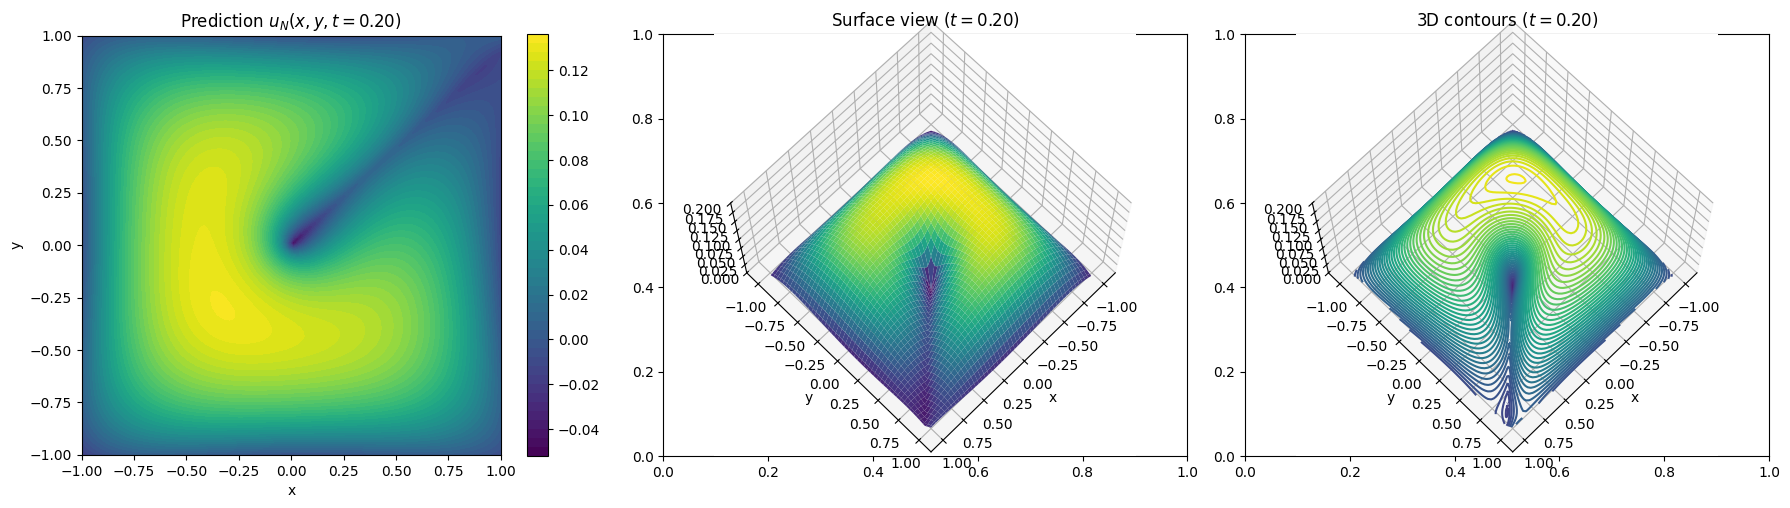

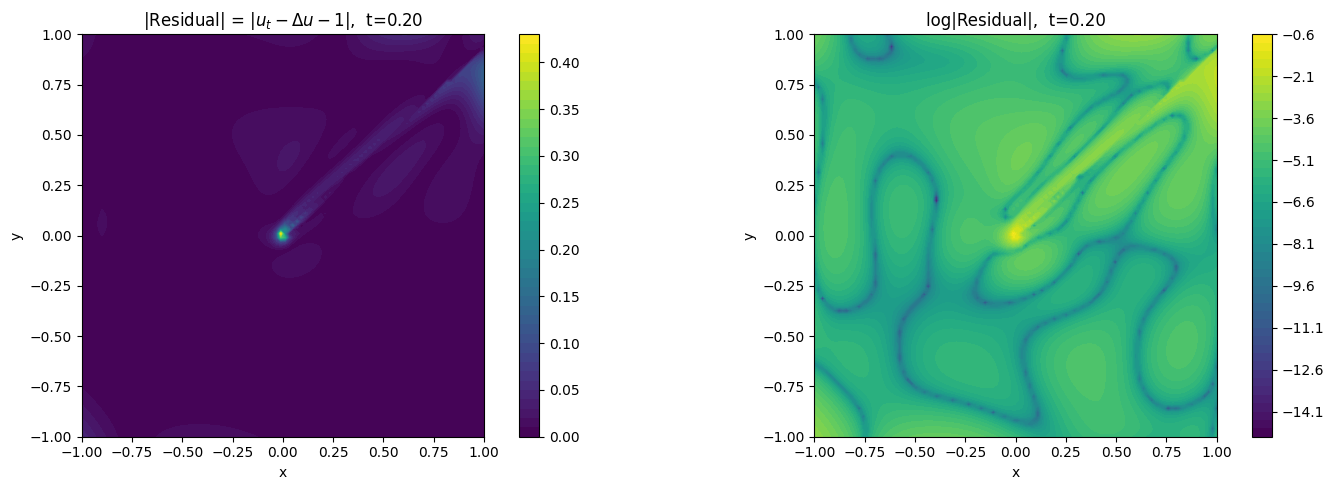

In [33]:
# test 
t0 = 0.2
nx = 100
xs = np.linspace(X_MIN, X_MAX, nx)
ys = np.linspace(Y_MIN, Y_MAX, nx)
Xg, Yg = np.meshgrid(xs, ys)

x_grid = torch.from_numpy(Xg.flatten()[:,None]).to(device).double()
y_grid = torch.from_numpy(Yg.flatten()[:,None]).to(device).double()
t_grid = torch.full_like(x_grid, t0).to(device)  # 全部時間都固定為 t0

# simpler phi (for inference / plotting, no grad) 
def compute_phi(x, y, t):
    eps = 1e-12
    x = x.view(-1,1).to(device)
    y = y.view(-1,1).to(device)
    t = t.view(-1,1).to(device)
    a = alpha(t)
    r = torch.sqrt(torch.clamp(x**2 + y**2, min=eps))
    inside = 0.5 * (r - (x * torch.cos(a) + y * torch.sin(a)))
    inside = torch.clamp(inside, min=1e-12)
    return torch.sqrt(inside)


with torch.no_grad():
    phi_grid = compute_phi(x_grid, y_grid, t_grid)

# 預測 u
with torch.no_grad():
    inp_grid = torch.cat([x_grid, y_grid, phi_grid, t_grid], dim=1)
    u_pred = model(inp_grid).cpu().numpy().reshape(nx, nx)

fig, axs = plt.subplots(1, 3, figsize=(18,5))

im0 = axs[0].contourf(Xg, Yg, u_pred, 50, cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title(f'Prediction $u_N(x,y,t={t0:.2f})$')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')


ax1 = fig.add_subplot(132, projection='3d')
ax1.plot_surface(Xg, Yg, u_pred, cmap='viridis', edgecolor='none')
ax1.set_title(f'Surface view ($t={t0:.2f}$)')
ax1.set_xlabel('x'); ax1.set_ylabel('y')
ax1.view_init(elev=70, azim=45)
ax1.set_zlim(0, 0.2)

ax2 = fig.add_subplot(133, projection='3d')
ax2.contour3D(Xg, Yg, u_pred, 50, cmap='viridis')
ax2.set_title(f'3D contours ($t={t0:.2f}$)')
ax2.set_xlabel('x'); ax2.set_ylabel('y')
ax2.view_init(elev=70, azim=45)
ax2.set_zlim(0, 0.2)

plt.tight_layout()
plt.show()

# 殘差圖 
res, _, _, _, _ = compute_residual_time(model, x_grid, y_grid, t_grid)
abs_residual = torch.abs(res).detach().cpu().numpy().reshape(nx, nx)
log_abs_residual = np.log(abs_residual + 1e-12)  


fig, axs = plt.subplots(1, 2, figsize=(15,5))
im0 = axs[0].contourf(Xg, Yg, abs_residual, 50, cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title(f'|Residual| = |$u_t - \\Delta u - 1$|,  t={t0:.2f}')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y'); axs[0].set_aspect('equal')

im1 = axs[1].contourf(Xg, Yg, log_abs_residual, 50, cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title(f'log|Residual|,  t={t0:.2f}')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y'); axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()


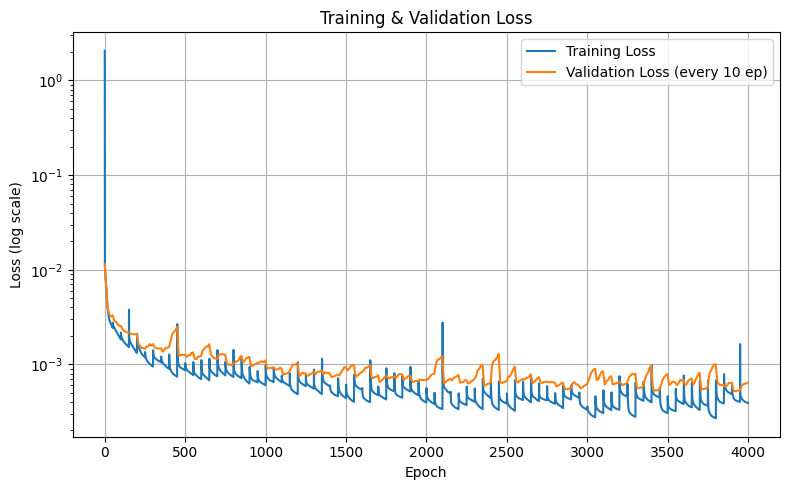

In [28]:
# loss 
epochs_arr = np.arange(len(loss_history))
val_epochs = np.linspace(0, len(loss_history)-1, len(val_history))
plt.figure(figsize=(8,5))
plt.semilogy(epochs_arr, loss_history, label='Training Loss')
plt.semilogy(val_epochs, val_history, label='Validation Loss (every 10 ep)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


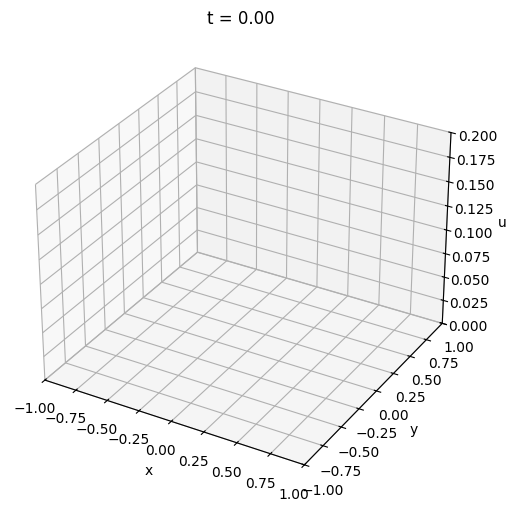

In [29]:
from matplotlib import animation

# ===== animation settings =====
t_start = 0.0
t_end = 0.25
num_frames = 60
t_values = np.linspace(t_start, t_end, num_frames)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

def init():
    ax.clear()
    ax.set_xlim(X_MIN, X_MAX)
    ax.set_ylim(Y_MIN, Y_MAX)
    ax.set_zlim(0, 0.2)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("u")
    ax.set_title("t = 0.00")
    return []

def update(frame_idx):
    ax.clear()

    ax.set_xlim(X_MIN, X_MAX)
    ax.set_ylim(Y_MIN, Y_MAX)
    ax.set_zlim(0, 0.2)

    t0 = t_values[frame_idx]
    t_grid = torch.full_like(x_grid, t0).to(device)

    with torch.no_grad():
        phi_grid = compute_phi(x_grid, y_grid, t_grid)
        inp_grid = torch.cat([x_grid, y_grid, phi_grid, t_grid], dim=1)
        u_pred = model(inp_grid)
        U = u_pred.cpu().numpy().reshape(nx, nx)

    surf = ax.plot_surface(Xg, Yg, U, cmap='viridis', edgecolor='none')

    ax.view_init(elev=45, azim=22.5)
    ax.set_title(f"u_N(x,y,t={t0:.2f})")

    # <<<< 必須回傳 artist，不可以 return [] >>>>
    return [surf]

ani = animation.FuncAnimation(
    fig, update, frames=num_frames, init_func=init, blit=False
)

 #====== 儲存動畫 ======
#from matplotlib.animation import PillowWriter
#writer = PillowWriter(fps=20)
#ani.save("u_surface_animation2.gif", writer=writer)
